# **Assignment 3 for Computational Semantics**

**Topic**: SemEval 2020 Task 4 Commonsense validation, explanation and generation

**Member**: Sijie Ju

**Introduction**: The task is to test whether a model can differentiate natural language statements that make sense from those that do not make sense. This task contains three subtasks. The following codes is the first solution to subtask A, which I used the adapter to finetune the model.



### **Subtask A**: Commonsense verification

**The subtask A** is to choose from two natural language statements with similar words which one makes sense and which one does not make sense.

**Examples**

>Which statement of the two is against common sense?
>
>Statement 1: He put a turkey into the fridge. (correct)
>
>Statement 2: He put an elephant into the fridge.

### **1. Load a pretained model**

In [ ]:
# INSTALL MISSING PACKAGES
from importlib.util import find_spec
import pip

required_packages = ['torch', 'pandas']

for package in required_packages:
  if find_spec(package) is None:
    print(f'Installing package: {package}...')
    pip.main(['install', package])

!pip install datasets==2.11.0
!pip uninstall transformers
!pip uninstall adapter-transformers
!pip install -U adapter-transformers

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.7 MB/s eta 0:00:00
Found existing installation: transformers 4.35.2
Uninstalling transformers-4.35.2:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.10/dist-packages/transformers-4.35.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/transformers/*
Proceed (Y/n)? Y
  Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# IMPORT PACKAGES
import pandas as pd
from pandas import DataFrame
import numpy as np
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import torch

import datasets
from datasets import Dataset, DatasetDict

import transformers
from transformers import BertTokenizer, BertModel
from transformers import pipeline
from transformers import AutoConfig, AutoTokenizer, AutoModelWithHeads, AutoModelForSequenceClassification
from transformers import TrainingArguments, AdapterTrainer, EvalPrediction

from transformers import TextClassificationPipeline
from transformers import TrainerCallback

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True,
                                  )

/usr/local/lib/python3.10/dist-packages/transformers/adapters/__init__.py:27: FutureWarning: The `adapter-transformers` package is deprecated and replaced by the `adapters` package. See https://docs.adapterhub.ml/transitioning.html.
  warnings.warn(


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### **2. Data processing**

In [ ]:
# download the data
!git clone https://github.com/wangcunxiang/SemEval2020-Task4-Commonsense-Validation-and-Explanation.git

fatal: destination path 'SemEval2020-Task4-Commonsense-Validation-and-Explanation' already exists and is not an empty directory.


In [ ]:
# load the data

def read_data(text_path,answer_path):
  text = pd.read_csv(text_path, header = 0, names = ['ID','Sentence 0','Sentence 1'])
  answer = pd.read_csv(answer_path, header = None, names = ['ID','Answer'])
  return text, answer

train_text, train_answer = read_data ('/content/SemEval2020-Task4-Commonsense-Validation-and-Explanation/ALL data/Training  Data/subtaskA_data_all.csv','/content/SemEval2020-Task4-Commonsense-Validation-and-Explanation/ALL data/Training  Data/subtaskA_answers_all.csv')
val_text,val_answer = read_data('/content/SemEval2020-Task4-Commonsense-Validation-and-Explanation/ALL data/Dev Data/subtaskA_dev_data.csv','/content/SemEval2020-Task4-Commonsense-Validation-and-Explanation/ALL data/Test Data/subtaskA_gold_answers.csv')
test_text, test_answer = read_data ('/content/SemEval2020-Task4-Commonsense-Validation-and-Explanation/ALL data/Test Data/subtaskA_test_data.csv','/content/SemEval2020-Task4-Commonsense-Validation-and-Explanation/ALL data/Test Data/subtaskA_gold_answers.csv')


def data_process(text,answer):
  text['Combined'] = text.iloc[:, -2:].apply(lambda row: ' '.join(map(str, row)), axis=1)
  data = text.merge(answer, on = 'ID',how = 'left')
  data = data.drop(labels = 'ID',axis =1)
  data['Answer']=data['Answer'].astype('object')
  return data

train_data = data_process(train_text,train_answer)
val_data = data_process(val_text, val_answer)
test_data = data_process(test_text,test_answer)

train_data.sample(10)

,Sentence 0,Sentence 1,Combined,Answer
6859,Hippos have patterns,Leopards have patterns,Hippos have patterns Leopards have patterns,0
7869,We often use chopsticks to eat noodles.,We often use a spatula to eat noodles.,We often use chopsticks to eat noodles. We oft...,1
9007,the cow jumped over the fence and escaped,the cow jumped over the moon and escaped,the cow jumped over the fence and escaped the ...,1
2542,running is more restful than walking,walking is more restful than running,running is more restful than walking walking i...,0
3233,The athlete jumped over Mount Everest.,The athlete successfully jumped over the high ...,The athlete jumped over Mount Everest. The ath...,0
1834,The fish lived at the bottom of the sea.,The man lived at the bottom of the sea.,The fish lived at the bottom of the sea. The m...,1
829,"When there is a serious accident, you call 911","When there is a serious accident, you call 922","When there is a serious accident, you call 911...",1
2293,she went to a dentist to check her tooth,she went to a dentist to check her eyes,she went to a dentist to check her tooth she w...,1
3125,You need a gun to travel abroad.,You need a passport to travel abroad.,You need a gun to travel abroad. You need a pa...,0
21,My brother placed the car inside the box.,My brother placed the nuclear reactor inside t...,My brother placed the car inside the box. My b...,1


In [ ]:
max_len = train_data['Combined'].apply(lambda x: len(x)).min()
print(max_len)

23


In [ ]:
# convert to dataset
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

In [ ]:
# encode the data
def encode_batch(batch):
  return tokenizer(batch['Sentence 0'],batch['Sentence 1'], max_length = 128, truncation=True, padding="max_length")

dataset = dataset.map(encode_batch, batched=True)
dataset = dataset.rename_column("Answer", "labels")

dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

### **3. Train the model**

In [ ]:
# set the configuration
config = AutoConfig.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    id2label={0: int(0), 1: int(1)}
)


# Load the pre-trained BERT model for sequence classification with the above configuration
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",  # Specifies the pre-trained model to use
    config=config
)

# Load the tokenizer for the 'bert-base-uncased' model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


# Adding an adapter to the model
model.add_adapter("sst")
model.train_adapter(["sst"])
model.set_active_adapters(["sst"])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [ ]:
training_args = TrainingArguments(
    learning_rate=4e-4,#5e-4,1e-4,1e-5,5e-5
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_steps=100,
    output_dir="./training_output",
    overwrite_output_dir=True,
    remove_unused_columns=False,
)


# Define a class to keep track of the loss during training
class LossLoggingCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
      print(f"Logging at step {state.global_step}: {logs}")

      if 'loss' in logs:
          self.losses.append(logs['loss'])

loss_logging_callback = LossLoggingCallback()

In [ ]:
# compute the accuracy during training
def compute_accuracy(p: EvalPrediction):
  preds = np.argmax(p.predictions, axis=1)
  print((preds == p.label_ids).mean())
  return {"eval_acc": (preds == p.label_ids).mean()}

In [ ]:
# start training
trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_accuracy,
    callbacks=[loss_logging_callback]
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10000
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 6250
  Number of trainable parameters = 896066


Step,Training Loss
100,0.704200
200,0.704000
300,0.700100
400,0.700600
500,0.696800
600,0.698300
700,0.698600
800,0.698500
900,0.694300
1000,0.553200


Logging at step 100: {'loss': 0.7042, 'learning_rate': 0.000492, 'epoch': 0.16}
Logging at step 200: {'loss': 0.704, 'learning_rate': 0.000484, 'epoch': 0.32}
Logging at step 300: {'loss': 0.7001, 'learning_rate': 0.00047599999999999997, 'epoch': 0.48}
Logging at step 400: {'loss': 0.7006, 'learning_rate': 0.00046800000000000005, 'epoch': 0.64}


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/sst/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/sst/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/sst/head_config.json
Module weights saved in ./training_output/checkpoint-500/sst/pytorch_model_head.bin


Logging at step 500: {'loss': 0.6968, 'learning_rate': 0.00046, 'epoch': 0.8}
Logging at step 600: {'loss': 0.6983, 'learning_rate': 0.00045200000000000004, 'epoch': 0.96}
Logging at step 700: {'loss': 0.6986, 'learning_rate': 0.000444, 'epoch': 1.12}
Logging at step 800: {'loss': 0.6985, 'learning_rate': 0.000436, 'epoch': 1.28}
Logging at step 900: {'loss': 0.6943, 'learning_rate': 0.000428, 'epoch': 1.44}


Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/sst/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/sst/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/sst/head_config.json
Module weights saved in ./training_output/checkpoint-1000/sst/pytorch_model_head.bin


Logging at step 1000: {'loss': 0.5532, 'learning_rate': 0.00042, 'epoch': 1.6}
Logging at step 1100: {'loss': 0.5021, 'learning_rate': 0.000412, 'epoch': 1.76}
Logging at step 1200: {'loss': 0.4478, 'learning_rate': 0.000404, 'epoch': 1.92}
Logging at step 1300: {'loss': 0.4023, 'learning_rate': 0.00039600000000000003, 'epoch': 2.08}
Logging at step 1400: {'loss': 0.3621, 'learning_rate': 0.000388, 'epoch': 2.24}


Saving model checkpoint to ./training_output/checkpoint-1500
Configuration saved in ./training_output/checkpoint-1500/sst/adapter_config.json
Module weights saved in ./training_output/checkpoint-1500/sst/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1500/sst/head_config.json
Module weights saved in ./training_output/checkpoint-1500/sst/pytorch_model_head.bin


Logging at step 1500: {'loss': 0.3827, 'learning_rate': 0.00038, 'epoch': 2.4}
Logging at step 1600: {'loss': 0.3605, 'learning_rate': 0.000372, 'epoch': 2.56}
Logging at step 1700: {'loss': 0.3693, 'learning_rate': 0.000364, 'epoch': 2.72}
Logging at step 1800: {'loss': 0.3494, 'learning_rate': 0.000356, 'epoch': 2.88}
Logging at step 1900: {'loss': 0.2978, 'learning_rate': 0.000348, 'epoch': 3.04}


Saving model checkpoint to ./training_output/checkpoint-2000
Configuration saved in ./training_output/checkpoint-2000/sst/adapter_config.json
Module weights saved in ./training_output/checkpoint-2000/sst/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-2000/sst/head_config.json
Module weights saved in ./training_output/checkpoint-2000/sst/pytorch_model_head.bin


Logging at step 2000: {'loss': 0.2854, 'learning_rate': 0.00034, 'epoch': 3.2}
Logging at step 2100: {'loss': 0.2569, 'learning_rate': 0.00033200000000000005, 'epoch': 3.36}
Logging at step 2200: {'loss': 0.2616, 'learning_rate': 0.000324, 'epoch': 3.52}
Logging at step 2300: {'loss': 0.2539, 'learning_rate': 0.000316, 'epoch': 3.68}
Logging at step 2400: {'loss': 0.2872, 'learning_rate': 0.000308, 'epoch': 3.84}


Saving model checkpoint to ./training_output/checkpoint-2500
Configuration saved in ./training_output/checkpoint-2500/sst/adapter_config.json
Module weights saved in ./training_output/checkpoint-2500/sst/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-2500/sst/head_config.json
Module weights saved in ./training_output/checkpoint-2500/sst/pytorch_model_head.bin


Logging at step 2500: {'loss': 0.2717, 'learning_rate': 0.0003, 'epoch': 4.0}
Logging at step 2600: {'loss': 0.1572, 'learning_rate': 0.000292, 'epoch': 4.16}
Logging at step 2700: {'loss': 0.1909, 'learning_rate': 0.00028399999999999996, 'epoch': 4.32}
Logging at step 2800: {'loss': 0.2061, 'learning_rate': 0.00027600000000000004, 'epoch': 4.48}
Logging at step 2900: {'loss': 0.1813, 'learning_rate': 0.000268, 'epoch': 4.64}


Saving model checkpoint to ./training_output/checkpoint-3000
Configuration saved in ./training_output/checkpoint-3000/sst/adapter_config.json
Module weights saved in ./training_output/checkpoint-3000/sst/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-3000/sst/head_config.json
Module weights saved in ./training_output/checkpoint-3000/sst/pytorch_model_head.bin


Logging at step 3000: {'loss': 0.2092, 'learning_rate': 0.00026000000000000003, 'epoch': 4.8}
Logging at step 3100: {'loss': 0.1872, 'learning_rate': 0.000252, 'epoch': 4.96}
Logging at step 3200: {'loss': 0.1594, 'learning_rate': 0.000244, 'epoch': 5.12}
Logging at step 3300: {'loss': 0.1357, 'learning_rate': 0.000236, 'epoch': 5.28}
Logging at step 3400: {'loss': 0.1157, 'learning_rate': 0.000228, 'epoch': 5.44}


Saving model checkpoint to ./training_output/checkpoint-3500
Configuration saved in ./training_output/checkpoint-3500/sst/adapter_config.json
Module weights saved in ./training_output/checkpoint-3500/sst/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-3500/sst/head_config.json
Module weights saved in ./training_output/checkpoint-3500/sst/pytorch_model_head.bin


Logging at step 3500: {'loss': 0.1483, 'learning_rate': 0.00022, 'epoch': 5.6}
Logging at step 3600: {'loss': 0.1367, 'learning_rate': 0.000212, 'epoch': 5.76}
Logging at step 3700: {'loss': 0.1412, 'learning_rate': 0.000204, 'epoch': 5.92}
Logging at step 3800: {'loss': 0.109, 'learning_rate': 0.00019600000000000002, 'epoch': 6.08}
Logging at step 3900: {'loss': 0.0941, 'learning_rate': 0.00018800000000000002, 'epoch': 6.24}


Saving model checkpoint to ./training_output/checkpoint-4000
Configuration saved in ./training_output/checkpoint-4000/sst/adapter_config.json
Module weights saved in ./training_output/checkpoint-4000/sst/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-4000/sst/head_config.json
Module weights saved in ./training_output/checkpoint-4000/sst/pytorch_model_head.bin


Logging at step 4000: {'loss': 0.0975, 'learning_rate': 0.00017999999999999998, 'epoch': 6.4}
Logging at step 4100: {'loss': 0.0967, 'learning_rate': 0.00017199999999999998, 'epoch': 6.56}
Logging at step 4200: {'loss': 0.0943, 'learning_rate': 0.000164, 'epoch': 6.72}
Logging at step 4300: {'loss': 0.0997, 'learning_rate': 0.000156, 'epoch': 6.88}
Logging at step 4400: {'loss': 0.111, 'learning_rate': 0.000148, 'epoch': 7.04}


Saving model checkpoint to ./training_output/checkpoint-4500
Configuration saved in ./training_output/checkpoint-4500/sst/adapter_config.json
Module weights saved in ./training_output/checkpoint-4500/sst/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-4500/sst/head_config.json
Module weights saved in ./training_output/checkpoint-4500/sst/pytorch_model_head.bin


Logging at step 4500: {'loss': 0.0692, 'learning_rate': 0.00014000000000000001, 'epoch': 7.2}
Logging at step 4600: {'loss': 0.0854, 'learning_rate': 0.000132, 'epoch': 7.36}
Logging at step 4700: {'loss': 0.0718, 'learning_rate': 0.000124, 'epoch': 7.52}
Logging at step 4800: {'loss': 0.0687, 'learning_rate': 0.00011600000000000001, 'epoch': 7.68}
Logging at step 4900: {'loss': 0.0961, 'learning_rate': 0.000108, 'epoch': 7.84}


Saving model checkpoint to ./training_output/checkpoint-5000
Configuration saved in ./training_output/checkpoint-5000/sst/adapter_config.json
Module weights saved in ./training_output/checkpoint-5000/sst/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-5000/sst/head_config.json
Module weights saved in ./training_output/checkpoint-5000/sst/pytorch_model_head.bin


Logging at step 5000: {'loss': 0.0772, 'learning_rate': 0.0001, 'epoch': 8.0}
Logging at step 5100: {'loss': 0.0538, 'learning_rate': 9.2e-05, 'epoch': 8.16}
Logging at step 5200: {'loss': 0.0789, 'learning_rate': 8.400000000000001e-05, 'epoch': 8.32}
Logging at step 5300: {'loss': 0.0576, 'learning_rate': 7.6e-05, 'epoch': 8.48}
Logging at step 5400: {'loss': 0.0545, 'learning_rate': 6.800000000000001e-05, 'epoch': 8.64}


Saving model checkpoint to ./training_output/checkpoint-5500
Configuration saved in ./training_output/checkpoint-5500/sst/adapter_config.json
Module weights saved in ./training_output/checkpoint-5500/sst/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-5500/sst/head_config.json
Module weights saved in ./training_output/checkpoint-5500/sst/pytorch_model_head.bin


Logging at step 5500: {'loss': 0.0496, 'learning_rate': 6e-05, 'epoch': 8.8}
Logging at step 5600: {'loss': 0.0438, 'learning_rate': 5.2e-05, 'epoch': 8.96}
Logging at step 5700: {'loss': 0.063, 'learning_rate': 4.4e-05, 'epoch': 9.12}
Logging at step 5800: {'loss': 0.0472, 'learning_rate': 3.6e-05, 'epoch': 9.28}
Logging at step 5900: {'loss': 0.0457, 'learning_rate': 2.8e-05, 'epoch': 9.44}


Saving model checkpoint to ./training_output/checkpoint-6000
Configuration saved in ./training_output/checkpoint-6000/sst/adapter_config.json
Module weights saved in ./training_output/checkpoint-6000/sst/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-6000/sst/head_config.json
Module weights saved in ./training_output/checkpoint-6000/sst/pytorch_model_head.bin


Logging at step 6000: {'loss': 0.0504, 'learning_rate': 2e-05, 'epoch': 9.6}
Logging at step 6100: {'loss': 0.0352, 'learning_rate': 1.2e-05, 'epoch': 9.76}
Logging at step 6200: {'loss': 0.0524, 'learning_rate': 4e-06, 'epoch': 9.92}




Training completed. Do not forget to share your model on huggingface.co/models =)




Logging at step 6250: {'train_runtime': 1526.695, 'train_samples_per_second': 65.501, 'train_steps_per_second': 4.094, 'total_flos': 6646476134400000.0, 'train_loss': 0.25164287506103517, 'epoch': 10.0}


TrainOutput(global_step=6250, training_loss=0.25164287506103517, metrics={'train_runtime': 1526.695, 'train_samples_per_second': 65.501, 'train_steps_per_second': 4.094, 'total_flos': 6646476134400000.0, 'train_loss': 0.25164287506103517, 'epoch': 10.0})

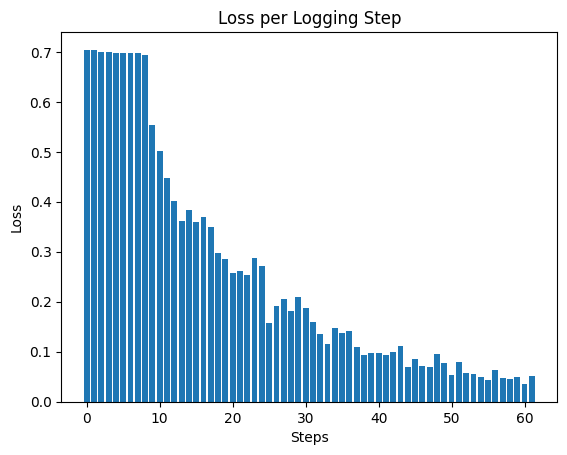

In [ ]:
# visualize the loss
plt.bar(range(len(loss_logging_callback.losses)), loss_logging_callback.losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss per Logging Step')
plt.show()

### **3. Test the model**

In [ ]:
#load the model
classifier = TextClassificationPipeline(model=model,
                                        tokenizer=tokenizer,
                                        device=training_args.device.index
                                        )

In [ ]:
# test the model
first_sentence = []
second_sentence = []
predictions = []
wrong_prediction = []
correct_count = 0
false_count = 0
count = 0

for text, answer in list(zip(test_data['Combined'], test_data['Answer'])):
  prediction = classifier(text)
  predictions.append(prediction[0]['label'])
  if answer == prediction[0]['label']:
    correct_count += 1
  else:
    false_count += 1
    first_sentence.append(test_data['Sentence 0'].iloc[count])
    second_sentence.append(test_data['Sentence 1'].iloc[count])
    wrong_prediction.append(prediction[0]['label'])
  count += 1

test_data['Prediction'] = predictions

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1048: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
# calculate teh test accuracy
test_accuracy = correct_count / count
print(f"The number of wrong prediction:{false_count}")
print("Model accuracy:{:.2%}".format(test_accuracy))

The number of wrong prediction:156
Model accuracy:84.40%


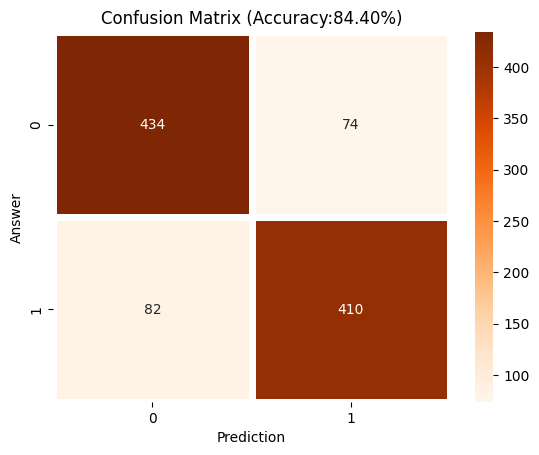

In [ ]:
# Display the confusion Matrix
import seaborn as sns
crosstab = pd.crosstab(test_data['Answer'],test_data['Prediction'])
sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
plt.title('Confusion Matrix (Accuracy:{:.2%})'.format(test_accuracy))
plt.show()

In [ ]:
#find the wrong prediction
wrong_predictions = pd.DataFrame({
    'Sentence 0':first_sentence,
    'Sentence 1':second_sentence,
    'Wrong prediction':wrong_prediction
    })

wrong_predictions.to_csv('Wrong prediction.csv',index=False)

pd.set_option('display.max_rows', None)
wrong_predictions